In [12]:
!conda env list


# conda environments:
#
base                   /home/ec2-user/anaconda3
JupyterSystemEnv       /home/ec2-user/anaconda3/envs/JupyterSystemEnv
R                      /home/ec2-user/anaconda3/envs/R
python3              * /home/ec2-user/anaconda3/envs/python3
pytorch_p310           /home/ec2-user/anaconda3/envs/pytorch_p310
tensorflow2_p310       /home/ec2-user/anaconda3/envs/tensorflow2_p310



In [26]:
import xml.etree.ElementTree as ET, os, glob
from shapely.geometry import Polygon
from concurrent.futures import ProcessPoolExecutor
from scipy.spatial.distance import pdist
import numpy as np, pandas as pd, tiffslide as ts, matplotlib.pyplot as plt, time, seaborn as sns
from skimage.measure import label, regionprops, regionprops_table
from read_labels import read_ome

In [2]:
# Helper function to compute centroid from a region
def compute_centroid(regions):
    centroids = []
    
    for region in regions:
        vertices = []
        for vertex in region.find(".//Vertices").findall("Vertex"):
            x = int(vertex.attrib['X'])
            y = int(vertex.attrib['Y'])
            vertices.append((x, y))
        if len(vertices) >= 3:
            poly = Polygon(vertices)
            centroids.append(poly.centroid)
        
    return centroids

In [28]:
from itertools import combinations
start = time.time()
tree = ET.parse("hubmap-data/Healthy-data/91647.xml")
root = tree.getroot()
regions = root.findall(".//Region")

# Parallel centroid computation
centroids = compute_centroid(regions)

# Filter valid centroids
# centroids = [r for r in results if r is not None]

# Compute pairwise distances using scipy
if centroids:
    centroids_array = np.array([(p.x, p.y) for p in centroids])
    distances = pdist(centroids_array)  # Efficient condensed distance matrix
    average_distance = distances.mean()
    print(f"Average centroid distance: {average_distance}")
    print(time.time() - start)

Average centroid distance: 33868.18919223864
31.672707080841064


In [7]:
# Load XML
annotations = glob.glob("hubmap-data/Healthy-data/*.xml")
dist = []
start_time = time.time()
for anno in annotations:
    tree = ET.parse(anno)
    root = tree.getroot()
    annotation = root.find('.//Annotation[@Id="5"]')
    regions = annotation.findall(".//Region")

    centroids = compute_centroid(regions)

    if centroids:
        centroids_array = np.array([(p.x, p.y) for p in centroids])
        distances = pdist(centroids_array)  # Efficient condensed distance matrix
        avg_dist = np.mean(distances)
        dist.append(avg_dist)
        print(f"Average centroid distance: {avg_dist}")

    print(f"{anno}_done")

Average centroid distance: 39628.40592183726
hubmap-data/Healthy-data/91726.xml_done
Average centroid distance: 27973.690055030744
hubmap-data/Healthy-data/91720.xml_done
Average centroid distance: 33187.937405658784
hubmap-data/Healthy-data/91710.xml_done
Average centroid distance: 42643.15276718033
hubmap-data/Healthy-data/H19-04732_1B1_PAS.xml_done
Average centroid distance: 40484.77415790696
hubmap-data/Healthy-data/H19-12283_1E1_PAS.xml_done
Average centroid distance: 32814.34914288059
hubmap-data/Healthy-data/91728.xml_done
Average centroid distance: 41179.93979058166
hubmap-data/Healthy-data/91730.xml_done
Average centroid distance: 39480.18813751571
hubmap-data/Healthy-data/91716.xml_done
Average centroid distance: 32951.180481992895
hubmap-data/Healthy-data/91651.xml_done
Average centroid distance: 22737.66024447942
hubmap-data/Healthy-data/91740.xml_done
Average centroid distance: 42341.160535214214
hubmap-data/Healthy-data/91746.xml_done
Average centroid distance: 34006.0823

In [8]:
with open("Healthy_tubule_dist.txt", "w") as fp:
    for d in dist:
        fp.write(f"{d}\n")

In [2]:
ratios = []
for ex in glob.glob("hubmap-data/hubmap-data/Disease_Data/*.xlsx"):
    df_sc = pd.read_excel(ex, sheet_name = "gs_glomeruli")
    df_n = pd.read_excel(ex, sheet_name = "non_gs_glomeruli")
    ratio = df_n.shape[0] / df_sc.shape[0]
    ratios.append(ratio)

In [9]:
folder_path = '/home/ec2-user/SageMaker/mapping/hubmap-data/hubmap-data/Disease_Data'

def get_annotations_from_tiff(file_path, page, downsample=1):
    data = read_ome(f"{folder_path}/{file_path}", page)
    return data


files = [f for f in os.listdir(folder_path) if f.endswith('ome.tiff')]
page = { 'non_gs': 1, 'gs': 2,}

num_ng, num_g = [], []
for file in files:
    data_non = get_annotations_from_tiff(file, page['non_gs'])
    data_gs = get_annotations_from_tiff(file, page['gs'])
    num_non = np.max(data_non)
    num_gs = np.max(data_gs)
    num_ng.append(num_non)
    num_g.append(num_gs)
    print(f"{file}_done")
    
ratios = np.array(num_ng) / np.array(num_g)

18-162_PAS_5of6.segmentations.ome.tiff_done
S-1908-010112_PAS_2of2.segmentations.ome.tiff_done
S-2006-002084_PAS_1of3.segmentations.ome.tiff_done
S-2106-003587_PAS_2of2.segmentations.ome.tiff_done
S-2002-005658_PAS_2of2.segmentations.ome.tiff_done
S-2001-000090_PAS_1of2.segmentations.ome.tiff_done
S-2101-000935_PAS_2of2.segmentations.ome.tiff_done
S-1908-000752_PAS_1of2.segmentations.ome.tiff_done
S-2006-002439_PAS_2of3.segmentations.ome.tiff_done
S-2006-001848_PAS_2of2.segmentations.ome.tiff_done
S-2006-004811_PAS_1of2.segmentations.ome.tiff_done
S-2006-001989_PAS_2of2.segmentations.ome.tiff_done
S-2002-007789_PAS_2of2.segmentations.ome.tiff_done
S-2102-006598_PAS_2of2.segmentations.ome.tiff_done
S-1910-000042_PAS_2of2.segmentations.ome.tiff_done
S-1908-009687_PAS_2of2.segmentations.ome.tiff_done
S-1909-007149_PAS_1of2.segmentations.ome.tiff_done
S-1904-007292_PAS_2of2.segmentations.ome.tiff_done
S-2006-004669_PAS_2of2.segmentations.ome.tiff_done
S-2006-002486_PAS_1of1.segmentations.o

In [10]:
with open("disease_ratios.txt", "w") as fp:
    for r in ratios:
        fp.write(f"{r}\n")

### Plot out the ratios and avg. dists between healthy and disease

In [18]:
with open('healthy_ratios.txt', 'r') as file:
    heal_r = [float(line.strip()) for line in file]
with open('disease_ratios.txt', 'r') as file:
    disease_r = [float(line.strip()) for line in file]
# with open('Disease_tubule_dist.txt', 'r') as file:
#     disease_tubule_dist = [line.strip() for line in file]
# with open('Healthy_tubule_dist.txt', 'r') as file:
#     heal_tb_dist = [line.strip() for line in file]

In [ ]:
# df = pd.DataFrame({
#     "Values": heal_r + disease_r,
#     "Group": ["healthy"] * len(heal_r) + ["disease"] * len(disease_r)
# })

# sns.violinplot(x='Group', y='Values', data=df)
# plt.title("Healthy vs Disease glomeruli: functional/non-funcional")

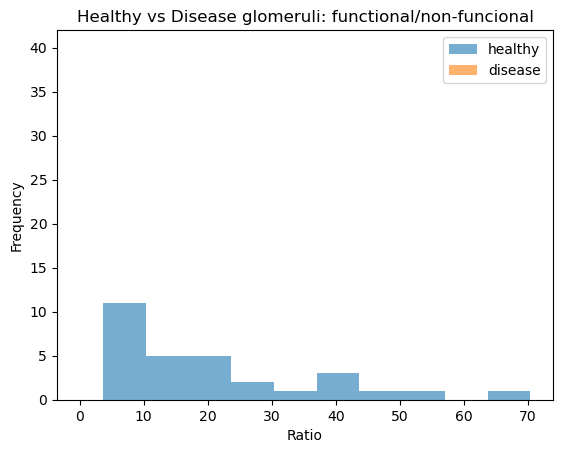

In [31]:
# plt.hist(heal_r, bins=10, alpha=0.6, label='healthy')
# plt.hist(disease_r, bins=10, alpha=0.6, label='disease')

# plt.xlabel('Ratio')
# plt.ylabel('Frequency')
# plt.title('Healthy vs Disease glomeruli: functional/non-funcional')
# plt.legend()
# plt.show()

/tmp/ipykernel_8865/3269392647.py:1: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([heal_r, disease_r], labels=['healthy', 'disease'])


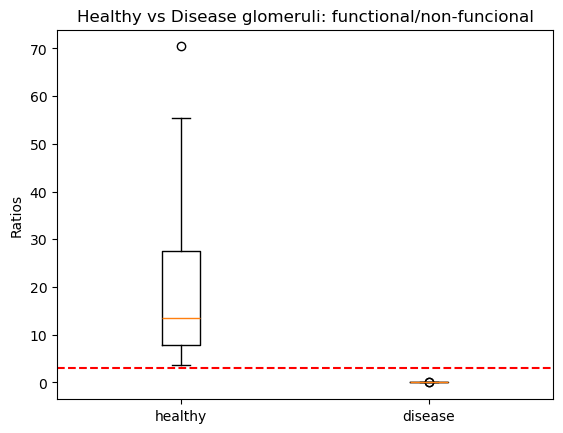

In [34]:
plt.boxplot([heal_r, disease_r], labels=['healthy', 'disease'])
plt.title('Healthy vs Disease glomeruli: functional/non-funcional')
plt.ylabel('Ratios')
plt.axhline(y = 3, color = "red", linestyle = "--")
plt.show()

### Tubule fibrosis analysis between disease and healthy (from excel)

In [44]:
heal_tb_fracs, dis_tb_fracs = [], []
for ex in glob.glob("hubmap-data/Healthy-data/*.xlsx"):
    heal_tb_data = pd.read_excel(ex, sheet_name = "tubules")
    heal_tb_fracs.append(np.mean(heal_tb_data["Luminal Fraction"].tolist()))

for ex in glob.glob("hubmap-data/hubmap-data/Disease_Data/*.xlsx"):
    dis_tb_data = pd.read_excel(ex, sheet_name = "Morphological Features")
    dis_tb_fracs.append(np.mean(dis_tb_data["Luminal Space Area By Object Area"].tolist()))

In [45]:
len(heal_tb_fracs)

30

In [47]:
dis_tb_fracs

[0.2764622479783551,
 0.3673877990297875,
 0.29704973347113317,
 0.3159388256771439,
 0.23860184027831446,
 0.20449660695769215,
 0.13782652879846932,
 0.31990355618713623,
 0.3813602213668157,
 0.2496741303612499,
 0.22380055063343493,
 0.25803959290730344,
 0.34384234259353685,
 0.45030489810080554,
 0.2500119598835431,
 0.2011598620058429,
 0.2425873940188435,
 0.2890080568517209,
 0.27561290205248634,
 0.24392321060946157,
 0.2686966643091574,
 0.22795512389647168,
 0.2410631380529377,
 0.46140438007063245,
 0.20837278468772286,
 0.36648217490903423,
 0.36749424649514806,
 0.12909099528826604,
 0.3143757255128925,
 0.19721626111935353,
 0.23084574438338204,
 0.28192213593506615,
 0.2908277392951362,
 0.4594196591172149,
 0.572645796277036,
 0.40503448082334353,
 0.2295713616870264,
 0.17013837307613813,
 0.3394733492046523,
 0.32607432082958115,
 0.35014112269370035,
 0.5954090106214955,
 0.40307059678146245,
 0.18941271235142085,
 0.24519216324260792,
 0.27891593960176375,
 0.3012

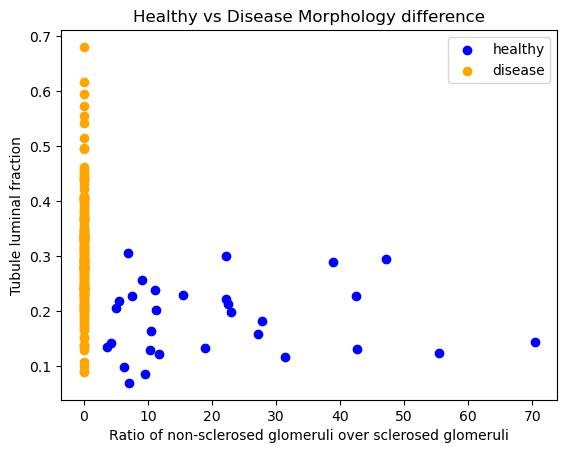

In [46]:
plt.scatter(heal_r, heal_tb_fracs, color = "blue", label = "healthy")
plt.scatter(disease_r[:len(dis_tb_fracs)], dis_tb_fracs, color = "orange", label = "disease")
plt.title("Healthy vs Disease Morphology difference")
plt.xlabel("Ratio of non-sclerosed glomeruli over sclerosed glomeruli")
plt.ylabel("Tubule luminal fraction")
plt.legend()
plt.show()

Text(0, 0.5, 'Tubule luminal fraction')

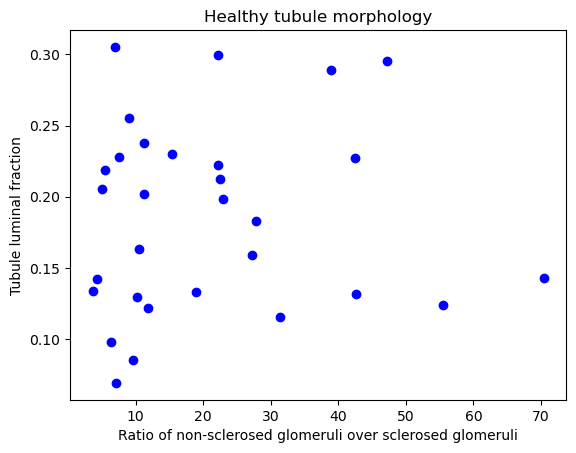

In [49]:
plt.scatter(heal_r, heal_tb_fracs, color = "blue", label = "healthy")
plt.title("Healthy tubule morphology")
plt.xlabel("Ratio of non-sclerosed glomeruli over sclerosed glomeruli")
plt.ylabel("Tubule luminal fraction")

Text(0, 0.5, 'Tubule luminal fraction')

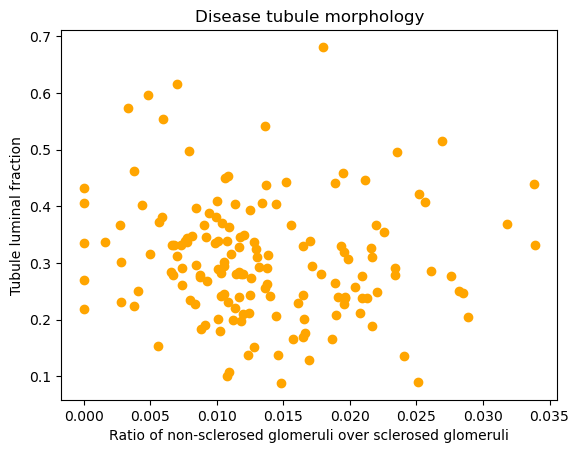

In [50]:
plt.scatter(disease_r[:len(dis_tb_fracs)], dis_tb_fracs, color = "orange", label = "disease")
plt.title("Disease tubule morphology")
plt.xlabel("Ratio of non-sclerosed glomeruli over sclerosed glomeruli")
plt.ylabel("Tubule luminal fraction")

In [ ]:
# plt.scatter(heal_r, heal_tb_dist, color = "blue", label = "healthy")
# plt.scatter(disease_r, disease_tb_dist, color = "orange", label = "disease")
# plt.label("Healthy vs Disease Morphology difference")
# plt.xlabel("Ratio of non-sclerosed glomeruli over sclerosed glomeruli")
# plt.ylabel("Avg distance between tubules")
# plt.legend()
# plt.show()

### Tubule fibrosis analysis between disease and healthy (incomplete)

In [ ]:
import tiffslide as ts
slide = ts.OpenSlide("hubmap-data/Healthy-data/91649.svs")

# Get full-resolution dimensions
width, height = slide.dimensions

In [7]:
slide_img = slide.read_region((0,0), slide.level_count - 1, slide.dimensions)

In [5]:
image = np.array(slide_img)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
inverted = 255 - gray

In [25]:
_, otsu_thresh = cv2.threshold(inverted, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

In [27]:
label_img = label(otsu_thresh)

In [30]:
props = regionprops_table(label_img, properties=[
    'area',
    'centroid'
])

In [33]:
df = pd.DataFrame(props)
df.head()

,area,centroid-0,centroid-1
0,883775.0,384.826742,718.553071
1,8.0,0.875000,24.125000
2,142.0,5.232394,41.795775
3,6.0,0.333333,576.500000
4,1.0,0.000000,619.000000


In [38]:
df.describe()

,area,centroid-0,centroid-1
count,231.000000,231.000000,231.000000
mean,3839.402597,367.662725,748.468483
std,58147.267006,239.341709,442.456463
min,1.000000,0.000000,12.117647
25%,2.000000,151.803030,381.846154
50%,4.000000,357.342857,745.857143
75%,11.500000,567.062500,1120.628571
max,883775.000000,768.333333,1442.000000


(array([190.,  25.,   9.,   1.,   1.,   0.,   1.,   1.,   0.,   1.]),
 array([  1. ,  15.1,  29.2,  43.3,  57.4,  71.5,  85.6,  99.7, 113.8,
        127.9, 142. ]),
 <BarContainer object of 10 artists>)

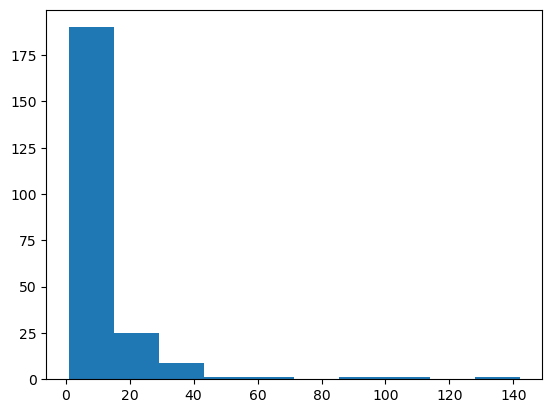

In [37]:
plt.hist(df['area'][df['area'] < 200])